# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 34115,
  "iopub_port": 51479,
  "stdin_port": 42359,
  "control_port": 36725,
  "hb_port": 57631,
  "ip": "127.0.0.1",
  "key": "bcae70a1-1a267fa64a4e9c3f901aa1c3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b736e99f-e16d-4c40-adcc-3d796a87ce27.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/nominal/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.01)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()

In [3]:
# generate scan points
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.114), (0.104, 0.114), (0.104, 0.114)], 
                                [5, 5, 5]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [4]:
# carry out the scan #

# minimizer options
min_options = dict(
                   #eps=1e-10,
                   gtol=1e-2, 
                   disp=True
                  )

results = []
cost = []
sv_accept = []
for sv in tqdm_notebook(scan_vals):
    
    # randomize n.p.
    mask = fit_data._pmask.copy()
    pinit = params_pre[fit_data._pmask]
    mask[:4] = False
    np_random = pinit[4:] + fit_data._perr_init[mask]*np.random.randn(mask.sum())
    fit_data._pval_init[mask] = np_random
    #sv[mask] = np_random
    mask[:4] = True
    
    # generate data from scan values w/ statistical variation
    sample = dict()
    for category in fit_data._categories:
        val, var = fit_data.mixture_model(sv, category)
        sample[category] = [np.random.poisson(val), val]

    # carry out minimization
    result = minimize(fit_data.objective, pinit,
                      method  = 'BFGS', 
                      options = min_options,
                      jac     = fit_data.objective_jacobian,
                      args    = (sample)
                     )
    print(' ', result.success, fit_data.objective(pinit), fit_data.objective(sv[mask]), result.fun)
    #print(' jacobian: ', result.jac)
    #print(' init vals: ', pinit)
    #print(' nps: ', np_random)
    print(' scan vals: ', sv[:4])
    print(' fit vals:', result.x[:4], end='\n\n')

    results.append(result.x)
    cost.append(result.fun)
    sv_accept.append(sv[mask])
    

Optimization terminated successfully.
         Current function value: 164.380814
         Iterations: 89
         Function evaluations: 107
         Gradient evaluations: 107
  True 1907.800089002553 2888.5495810771395 164.38081359267503
 scan vals:  [0.104 0.104 0.104 0.688]
 fit vals: [0.1031 0.1038 0.1056 0.6875]

         Current function value: 171.302128
         Iterations: 89
         Function evaluations: 195
         Gradient evaluations: 183
  False 1909.2164186193747 2783.1012472384714 171.30212798643697
 scan vals:  [0.104  0.104  0.1065 0.6855]
 fit vals: [0.1045 0.1048 0.1085 0.6822]

Optimization terminated successfully.
         Current function value: 177.941671
         Iterations: 91
         Function evaluations: 104
         Gradient evaluations: 104
  True 1895.840948447581 2685.3178683892165 177.9416708679785
 scan vals:  [0.104 0.104 0.109 0.683]
 fit vals: [0.1045 0.1031 0.1091 0.6833]

         Current function value: 184.191897
         Iterations: 85
     

Optimization terminated successfully.
         Current function value: 189.503166
         Iterations: 84
         Function evaluations: 121
         Gradient evaluations: 120
  True 1912.1397398222828 5116.975566132132 189.50316620644517
 scan vals:  [0.104 0.114 0.114 0.668]
 fit vals: [0.1045 0.1138 0.1132 0.6684]

         Current function value: 184.582987
         Iterations: 86
         Function evaluations: 261
         Gradient evaluations: 248
  False 1913.2967357100597 2367.4641486843993 184.58298688034267
 scan vals:  [0.1065 0.104  0.104  0.6855]
 fit vals: [0.1069 0.104  0.1056 0.6835]

         Current function value: 175.333985
         Iterations: 84
         Function evaluations: 149
         Gradient evaluations: 138
  False 1915.943739674271 2286.431529742517 175.3339850908288
 scan vals:  [0.1065 0.104  0.1065 0.683 ]
 fit vals: [0.1071 0.1046 0.1086 0.6797]

         Current function value: 162.675683
         Iterations: 82
         Function evaluations: 117
    

         Current function value: 174.462349
         Iterations: 84
         Function evaluations: 188
         Gradient evaluations: 175
  False 1906.3675256861695 4840.657841057978 174.46234896244067
 scan vals:  [0.1065 0.114  0.114  0.6655]
 fit vals: [0.1056 0.1146 0.1133 0.6665]

Optimization terminated successfully.
         Current function value: 179.522851
         Iterations: 83
         Function evaluations: 98
         Gradient evaluations: 98
  True 1898.6885328984708 2306.171305049607 179.52285089612636
 scan vals:  [0.109 0.104 0.104 0.683]
 fit vals: [0.1085 0.1047 0.1044 0.6824]

         Current function value: 197.645589
         Iterations: 80
         Function evaluations: 118
         Gradient evaluations: 109
  False 1910.4602403466495 2256.318658921859 197.64558855213275
 scan vals:  [0.109  0.104  0.1065 0.6805]
 fit vals: [0.1087 0.1038 0.1046 0.6829]

Optimization terminated successfully.
         Current function value: 184.343008
         Iterations: 87
  

Optimization terminated successfully.
         Current function value: 184.463587
         Iterations: 84
         Function evaluations: 194
         Gradient evaluations: 189
  True 1899.9094962711883 5040.218385060794 184.46358673689633
 scan vals:  [0.109 0.114 0.114 0.663]
 fit vals: [0.1082 0.1139 0.1135 0.6644]

Optimization terminated successfully.
         Current function value: 155.196970
         Iterations: 72
         Function evaluations: 117
         Gradient evaluations: 116
  True 1902.4088330664458 2722.9478823782556 155.19697048994877
 scan vals:  [0.1115 0.104  0.104  0.6805]
 fit vals: [0.1103 0.1031 0.1037 0.6829]

Optimization terminated successfully.
         Current function value: 179.192496
         Iterations: 78
         Function evaluations: 176
         Gradient evaluations: 175
  True 1920.2634191603631 2700.1736302949753 179.19249618106713
 scan vals:  [0.1115 0.104  0.1065 0.678 ]
 fit vals: [0.1116 0.1042 0.1098 0.6744]

Optimization terminated succes

Optimization terminated successfully.
         Current function value: 184.532402
         Iterations: 80
         Function evaluations: 99
         Gradient evaluations: 99
  True 1903.6968817616764 5706.6762383707355 184.5324022287181
 scan vals:  [0.1115 0.114  0.114  0.6605]
 fit vals: [0.1099 0.114  0.1131 0.6631]

         Current function value: 195.910734
         Iterations: 66
         Function evaluations: 107
         Gradient evaluations: 97
  False 1931.422449820558 3605.796544827054 195.9107336738948
 scan vals:  [0.114 0.104 0.104 0.678]
 fit vals: [0.1152 0.1032 0.1046 0.6769]

         Current function value: 203.394151
         Iterations: 64
         Function evaluations: 154
         Gradient evaluations: 144
  False 1897.8155545596328 3551.561139835176 203.39415070263942
 scan vals:  [0.114  0.104  0.1065 0.6755]
 fit vals: [0.1137 0.1032 0.108  0.675 ]

         Current function value: 195.391722
         Iterations: 65
         Function evaluations: 161
        

Optimization terminated successfully.
         Current function value: 193.672777
         Iterations: 93
         Function evaluations: 109
         Gradient evaluations: 109
  True 1901.2032230954335 6804.767594803671 193.6727772660752
 scan vals:  [0.114 0.114 0.114 0.658]
 fit vals: [0.115  0.114  0.1163 0.6547]




In [5]:
#calculate biases
results = np.array(results)
sv_accept = np.array(sv_accept)
cost = np.array(cost)

diff = (results - sv_accept)
diff[:,:4] /= 0.01*pinit[:4]
#diff[:,:4] /= 0.01*sv_accept[:,:4]
diff[:,4:diff.shape[1]] /= params['err_init'][4:diff.shape[1]].values

#diff = np.array([d for d in diff if np.all((d > -10) & (d < 10))])

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


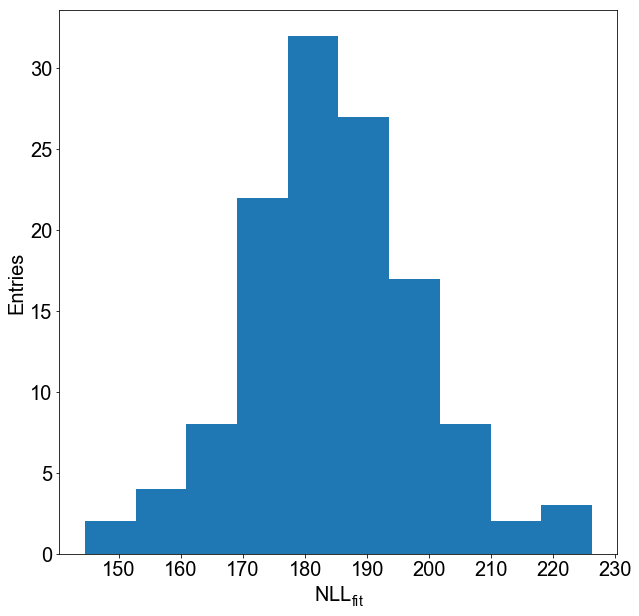

In [6]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

ax.hist(cost)#, bins=np.linspace(0, 50, 15))
ax.set_xlabel(r'$NLL_{fit}$')
ax.set_ylabel('Entries')

plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


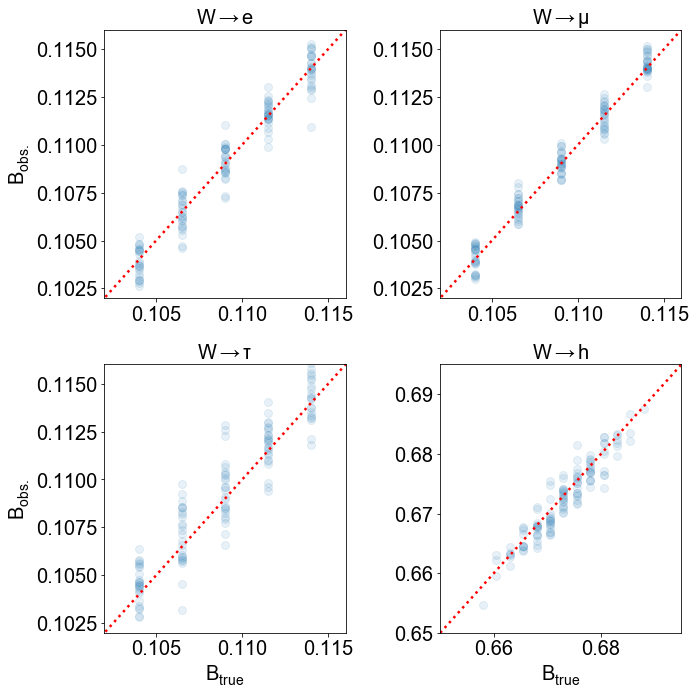

In [7]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=False, sharey=False)

beta_val = sv_accept[:,:4]
beta_obs = results[:,:4]

ax = axes[0][0]
ax.plot(beta_val[:,0], beta_obs[:,0], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.116)
ax.set_ylim(0.102, 0.116)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
ax.plot(beta_val[:,1], beta_obs[:,1], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.116)
ax.set_ylim(0.102, 0.116)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
ax.plot(beta_val[:,2], beta_obs[:,2], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.116)
ax.set_ylim(0.102, 0.116)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
ax.plot(beta_val[:,3], beta_obs[:,3], 'C0o', alpha=0.1)
ax.plot([0.65, 0.72], [0.65, 0.72], 'r:')
ax.set_xlim(0.65, 0.695)
ax.set_ylim(0.65, 0.695)
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_scan.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


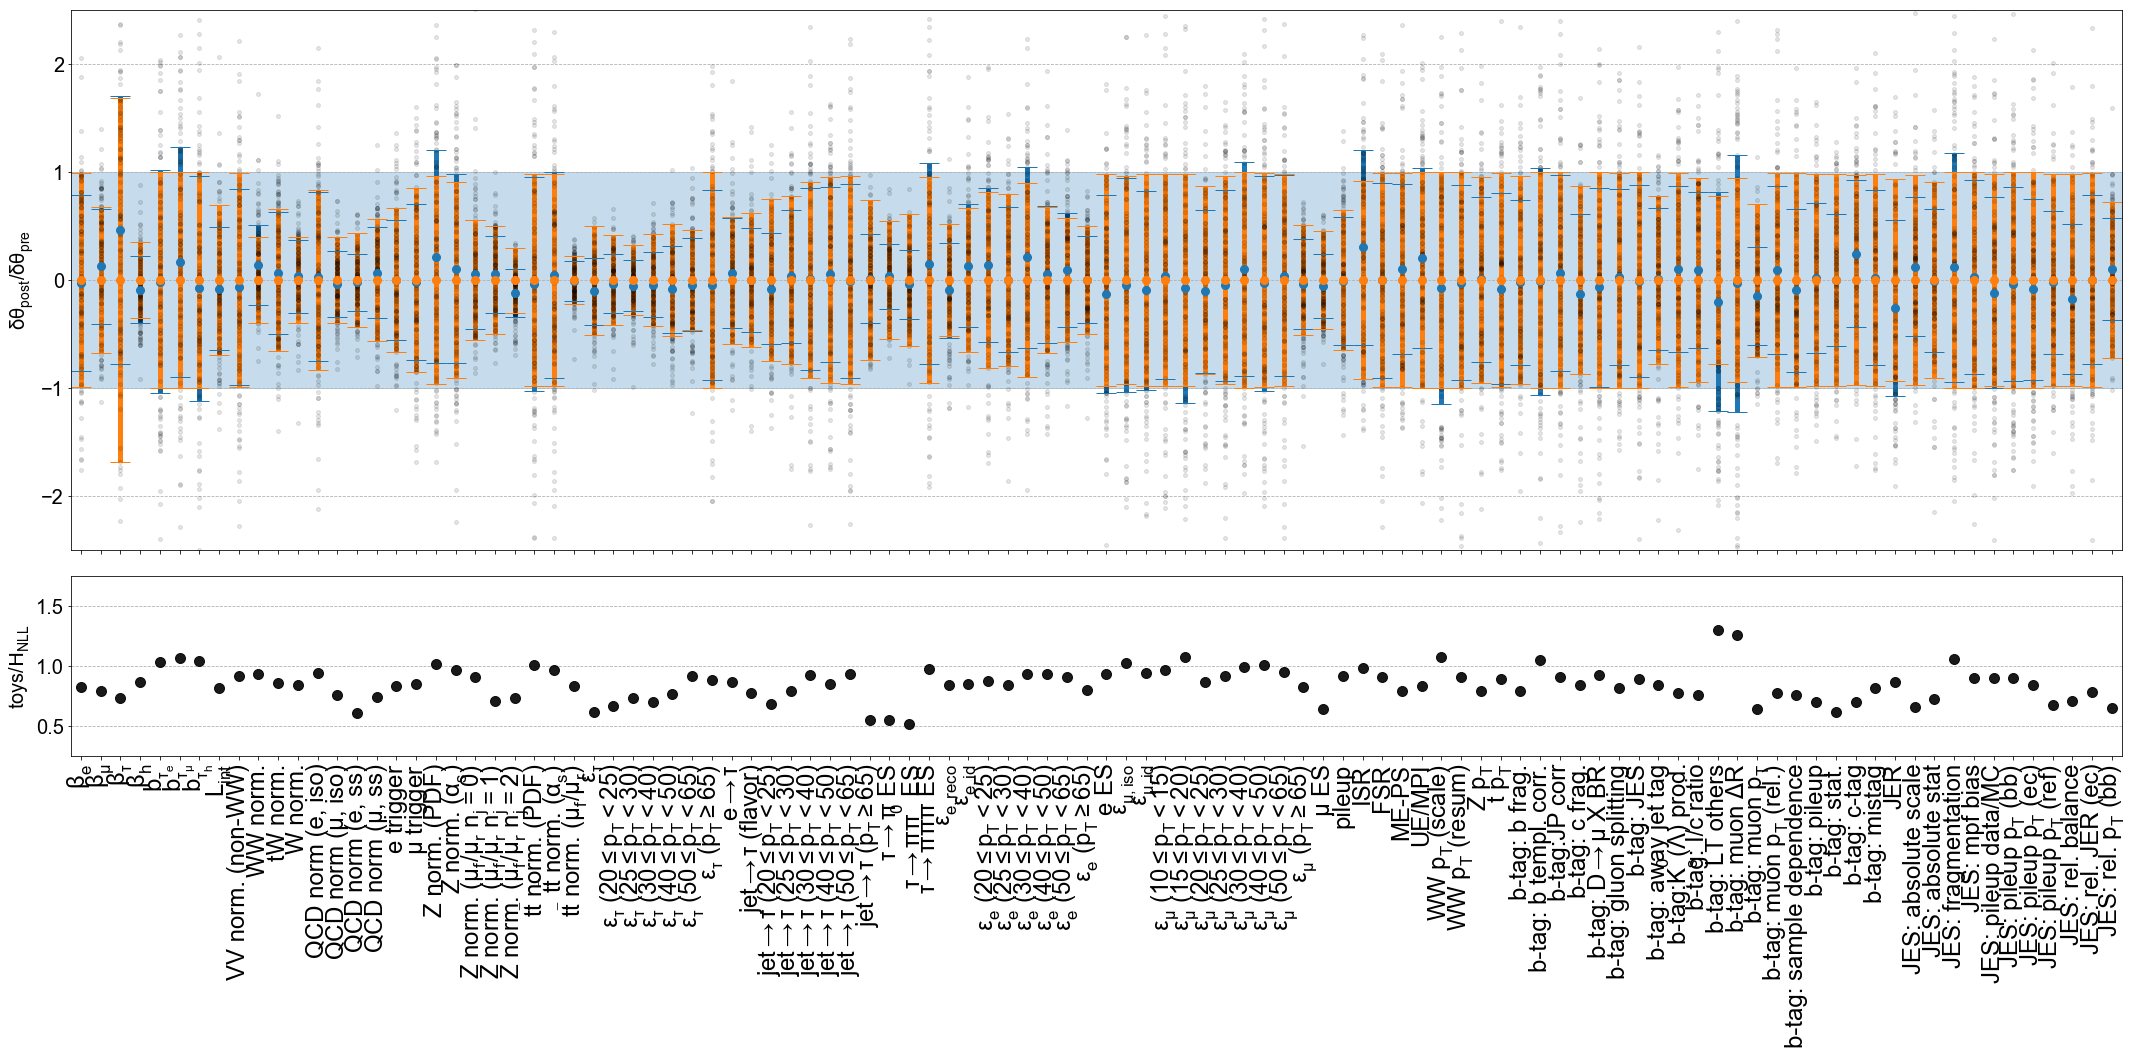

In [8]:
#plotting the results
fig, axes = plt.subplots(2, 1, figsize=(30, 15), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})

df_pulls = pd.read_csv('local_data/pulls.csv')
df_pulls.loc[:3, 'ratio'] *= 100

nparams = params[mask].shape[0]
xticks = np.outer(np.arange(nparams), np.ones(diff.shape[0])).T
ax = axes[0]
ax.plot(xticks+1,  diff, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff.mean(axis=0), diff.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.errorbar(xticks[0]+1,  np.zeros(xticks[0].size), df_pulls['ratio'], fmt='C1o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)
#ax.boxplot(diff)

# extra dressing
ax.set_ylabel(r'$\delta\theta_{post}/\delta\theta_{pre}$')
ax.set_xlim(0.5, nparams+0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

ax = axes[1]
err_ratio = diff.std(axis=0)/df_pulls['ratio'].values
ax.plot(xticks[0]+1,  err_ratio, 'ko', alpha=0.9, markersize=10)
#ax.errorbar(xticks[0]+1,  diff.mean(axis=0), , fmt='C0o', capsize=10, elinewidth=5)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label, size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'toys/$\mathcal{H}_{NLL}$')
ax.set_ylim(0.25, 1.75)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/new_pulls.pdf')
plt.show()

[0.818  0.5363 1.2424 0.3087]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


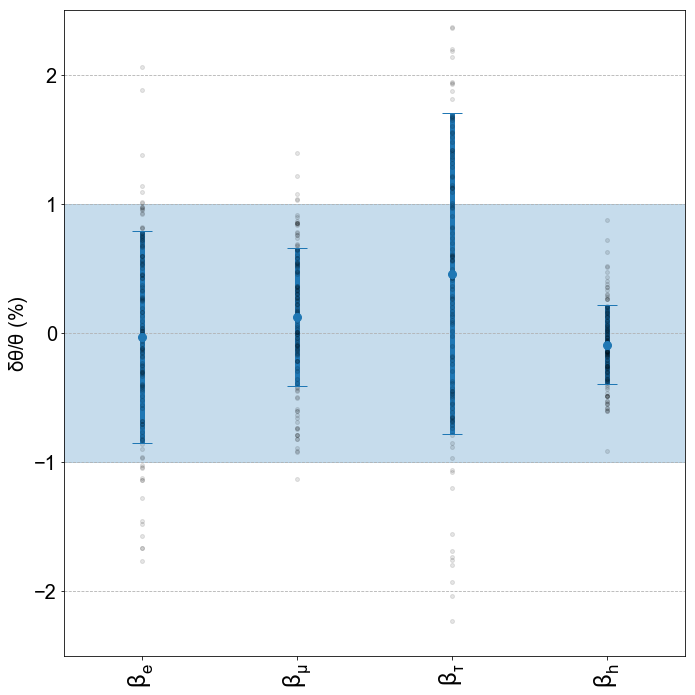

In [9]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

xticks = np.outer(np.arange(4), np.ones(diff.shape[0])).T
ax.plot(xticks+1,  diff[:,:4], 'ko', alpha=0.1, markersize=4)
#ax.boxplot(diff)
ax.errorbar(xticks[0,:4]+1,  diff[:,:4].mean(axis=0), diff[:,:4].std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

print(diff[:,:4].std(axis=0))

# extra dressing
ax.set_xticks(xticks[0,:4]+1)
ax.set_xticklabels(params.label[:4], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\delta\theta/\theta$ (%)')
ax.set_xlim(0.5, nparams+0.5)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


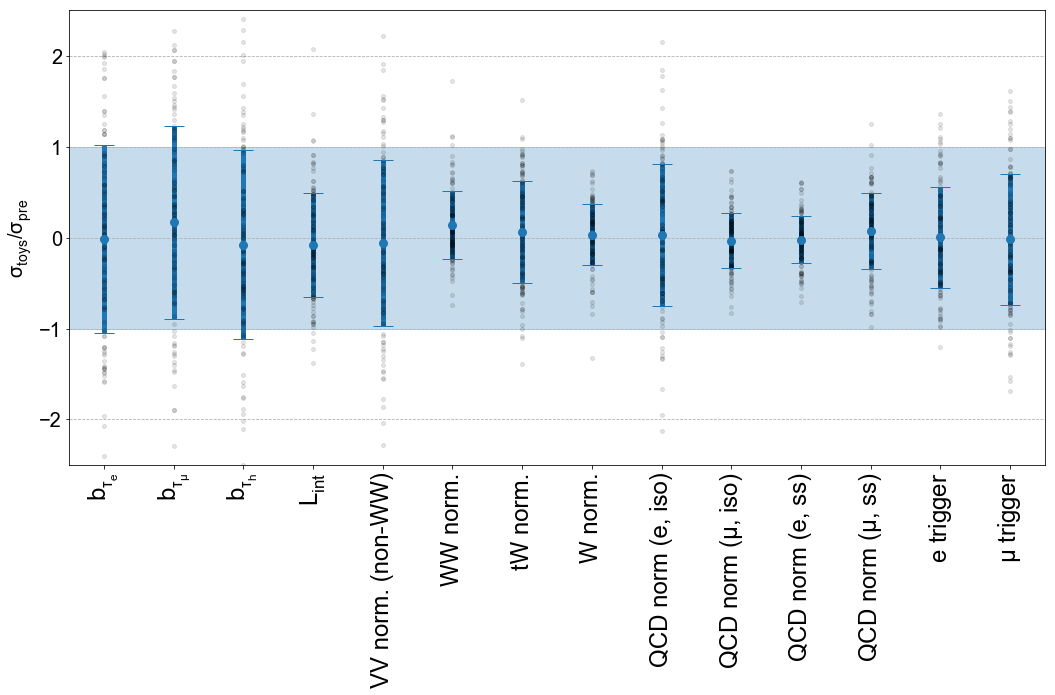

In [10]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor='white')

ip_low, ip_high = 4, 7 + fit_data._nnorm
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/norm_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


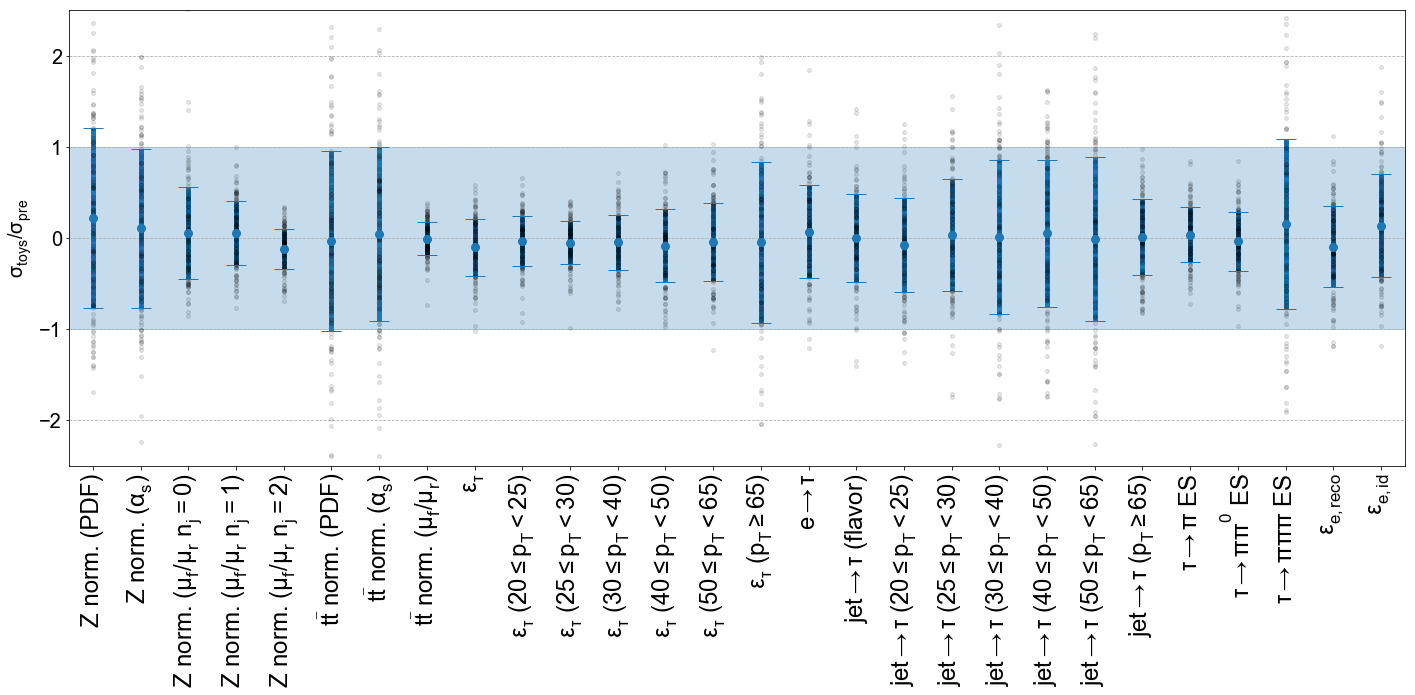

In [11]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 18, 46
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_reco_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


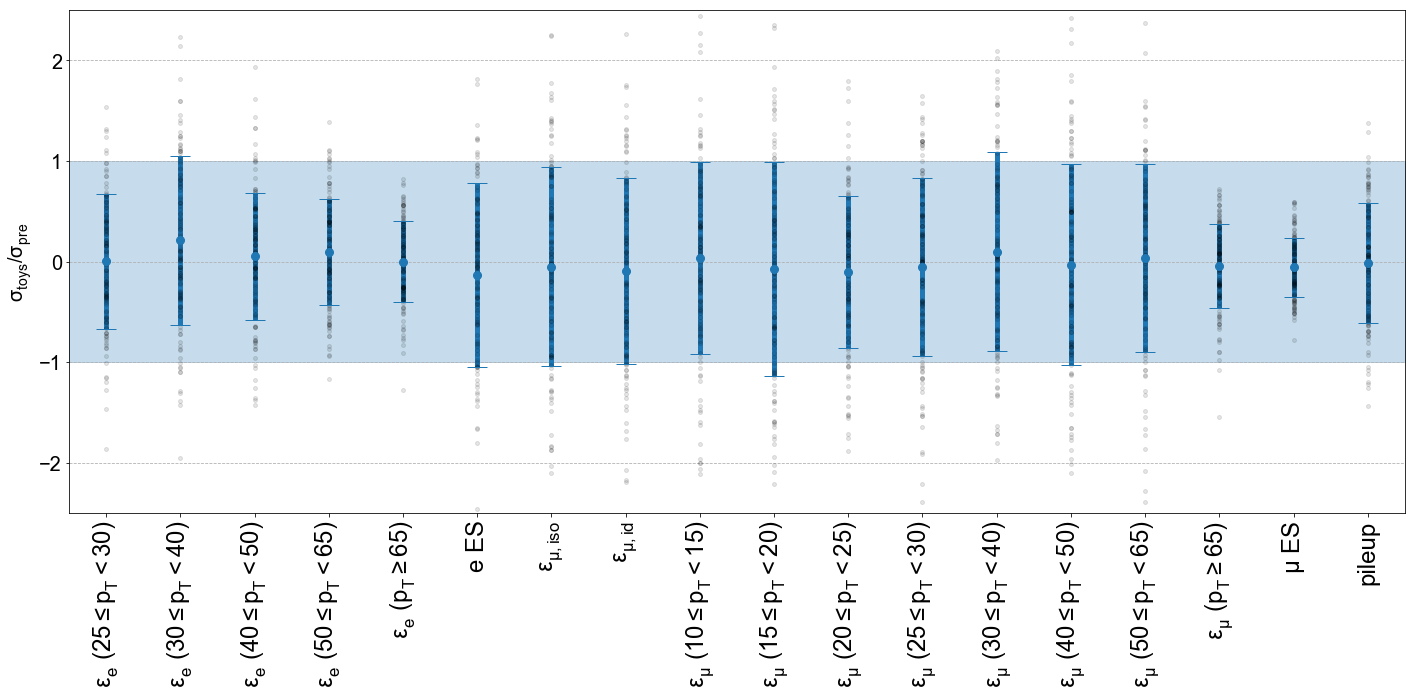

In [12]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 47, 65
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_btag_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


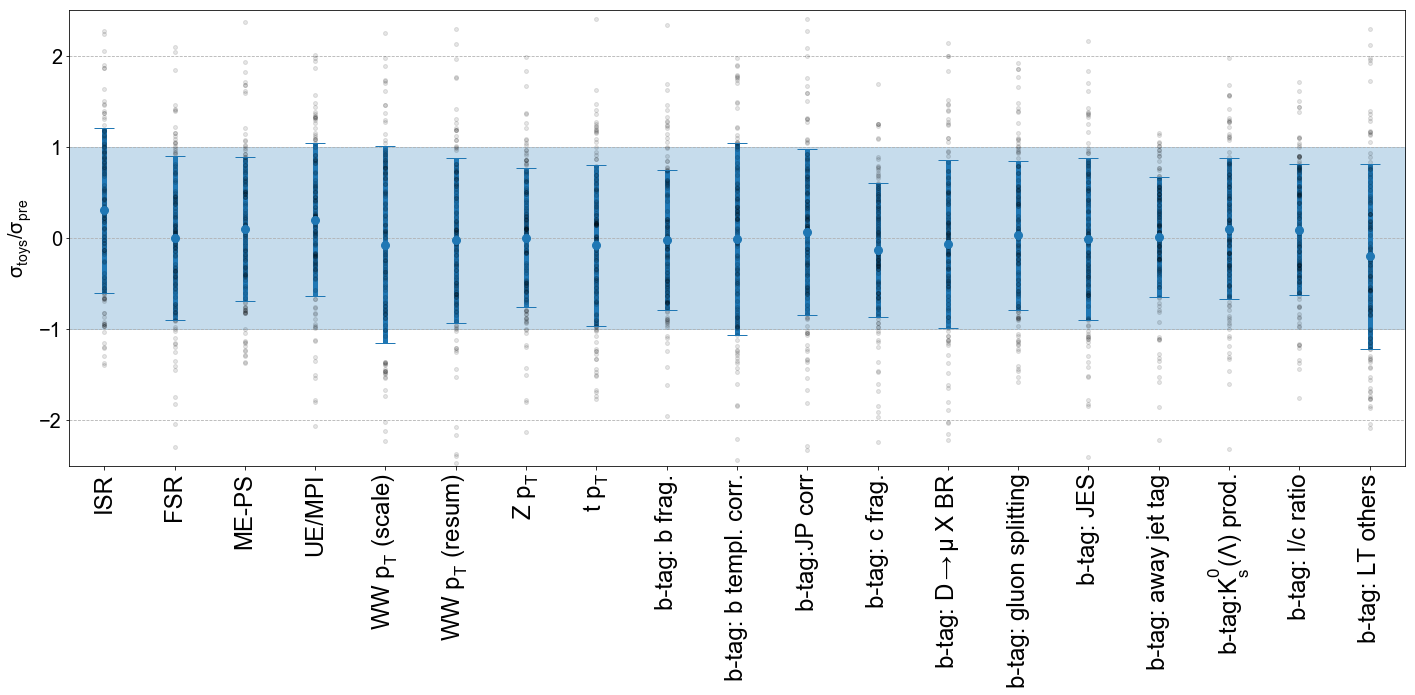

In [13]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 65, 84
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_jes_params.pdf')
plt.show()